The MIT License (MIT)<br>
Copyright (c) 2017 Massachusetts Institute of Technology

Author: Cody Rude<br>
This software is part of the NASA AIST Project "Computer-Aided Discovery of<br>
Earth Surface Deformation Phenomena" , PI: V. Pankratius

Permission is hereby granted, free of charge, to any person obtaining a copy<br>
of this software and associated documentation files (the "Software"), to deal<br>
in the Software without restriction, including without limitation the rights<br>
to use, copy, modify, merge, publish, distribute, sublicense, and/or sell<br>
copies of the Software, and to permit persons to whom the Software is<br>
furnished to do so, subject to the following conditions:

The above copyright notice and this permission notice shall be included in<br>
all copies or substantial portions of the Software.<br>
THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR<br>
IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY,<br>
FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE<br>
AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER<br>
LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM,<br>
OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN<br>
THE SOFTWARE.

Initial Setup

In [1]:
# 3rd party imports
import matplotlib.pyplot as plt
import matplotlib
from matplotlib.patches import Ellipse
import numpy as np
import pandas as pd
import scipy as sp
import re
import warnings
warnings.simplefilter("ignore")
from mpl_toolkits.basemap import Basemap
plt.rcParams['figure.figsize'] = (8.0, 8.0)
%matplotlib inline
from skdaccess.framework.param_class import *
from skdiscovery.data_structure.framework.stagecontainers import *
from tqdm import tqdm
from collections import OrderedDict
from skdiscovery.visualization.spherical_voronoi import getVoronoiCollection

In [2]:
# Scikit Data Access Imports
from skdaccess.geo.pbo import DataFetcher as PBODF
from skdaccess.geo.grace import DataFetcher as GDF


# Scikit Discovery (Renaming in progress)
from skdiscovery.data_structure.framework import DiscoveryPipeline
from skdiscovery.data_structure.table.filters import KalmanFilter, TrendFilter, SnowRemover, PropagateNaNs, WeightedAverage
from skdiscovery.data_structure.table.filters import AntennaOffset

from skdiscovery.data_structure.table.accumulators import Plotter
from skdiscovery.data_structure.generic.accumulators import DataAccumulator
from skdiscovery.data_structure.table.analysis import Correlate, General_Component_Analysis, MIDAS
from skdiscovery.data_structure.table.fusion import GraceFusion

Read in PBO metadata

In [3]:
metadata = pd.DataFrame.from_dict(PBODF.getStationMetadata(), orient='index')

Setup Data Fetcher

In [4]:
start_date='2002-02-04'
end_date='2015-06-01'

# AP Radius sets the lat/lon box size
al_box = AutoList((4.5,5))

# Create a meshgrid of lat lon coordinates over the entire US
lat_start = np.linspace(24,46.5,6)
lon_start = np.linspace(-125,-60,14)
sLat,sLon = np.meshgrid(lat_start,lon_start)
sLat = sLat.flatten()
sLon = sLon.flatten()
lat_boundaries = [(lat,lat+4.5) for lat in sLat]
lon_boundaries = [(lon,lon+5) for lon in sLon]

ap_lat_bounds = AutoListCycle(lat_boundaries)
ap_lon_bounds = AutoListCycle(lon_boundaries)

# Create a Data Fetcher that will data from the US in chunks
pbo_dg = PBODF(start_date,end_date,[ap_lat_bounds,ap_lon_bounds],mdyratio=0.30, use_progress_bar=False)

Setup Analysis Pipelines

In [5]:
# Filter to fix antenna offsets
fl_aoff = AntennaOffset('AntennaOffset', antenna_data=PBODF.getAntennaLogs())
sc_aoff = StageContainer(fl_aoff)

# Weighted average filter
fl_wa = WeightedAverage('WeightedAverage',[AutoParam(31)],['dU'],['Su'])
sc_wa = StageContainer(fl_wa)

# Filter to propogate nan's from one column to another
fl_pn = PropagateNaNs("PropagateNaNs",'Grace',['dU','Su'])
sc_pn = StageContainer(fl_pn)

# Item to save data
ac_data = DataAccumulator('Data',[])
sc_data = StageContainer(ac_data)

# Item to append a GRACE column to table data
fs_grace = GraceFusion('Grace',metadata,gldas='Off')
sc_grace = StageContainer(fs_grace)

# Spearman correlation analysis
ana_spearman = Correlate("Spearman",['dU','Grace'],local_match=True, correlation_type='spearman')
sc_spearman = StageContainer(ana_spearman)

# Pearson correlation analysis
ana_pearson = Correlate("Pearson",['dU','Grace'],local_match=True, correlation_type='pearson')
sc_pearson = StageContainer(ana_pearson)

# Filter to remove linear, annual, and semi annual signals
ftr_tf = TrendFilter('TrendFilter', [],columns=['dU','Grace']  )
sc_tf = StageContainer(ftr_tf)

# filter to only remove linear trend
ftr_ltf = TrendFilter('LinearFilter', [AutoList(['linear'])],columns=['dU','Grace']  )
sc_ltf = StageContainer(ftr_ltf)

# Pipeline with linear and seasonal trends removed
pbo_pipe = DiscoveryPipeline(pbo_dg, [sc_aoff, sc_grace,sc_tf, sc_wa,sc_pn,sc_data,sc_spearman, sc_pearson])

# Pipeline with only linear trends removed
pbo_pipe_only_linear = DiscoveryPipeline(pbo_dg, [sc_aoff, sc_grace,sc_ltf, sc_wa,sc_pn, sc_spearman, sc_pearson])

First pipeline

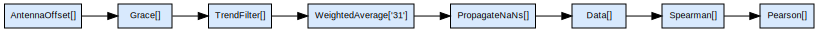

In [6]:
pbo_pipe.plotPipelineInstance()

In [7]:
# This may take a while (~20 minutes)
pbo_pipe.run(perturb_data=True,num_runs=len(lat_boundaries))

Second Pipeline

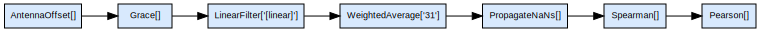

In [8]:
pbo_pipe_only_linear.plotPipelineInstance()

In [9]:
# This may take a while (~20 minutes)
pbo_pipe_only_linear.run(perturb_data=True,num_runs=len(lat_boundaries))

Extract results from first pipeline

In [10]:
pbo_name_list = []
pbo_pearson_list = []
pbo_spearman_list = []
for res in pbo_pipe.getResults():
    pearson = res['Pearson']
    spearman = res['Spearman']
    full_data = res['Data']
    for label in full_data.keys():
        pbo_name_list.append(label)
        pbo_pearson_list.append(pearson.loc[label, 'dU','Grace'])
        pbo_spearman_list.append(spearman.loc[label, 'dU','Grace'])
        
results_dict = OrderedDict()
results_dict['Spearman'] = pd.Series(pbo_spearman_list, index=pbo_name_list)
results_dict['Pearson'] = pd.Series(pbo_pearson_list, index=pbo_name_list)

results = pd.DataFrame(results_dict)
results.index.name = 'Station'
results['Lat'] = metadata.loc[results.index,'Lat']
results['Lon'] = metadata.loc[results.index,'Lon']
results.dropna(inplace=True)

Extract results from second, linear only, pipeline

In [11]:
pbo_name_list = []
pbo_pearson_list = []
pbo_spearman_list = []
for res in pbo_pipe_only_linear.getResults():
    pearson = res['Pearson']
    spearman = res['Spearman']
    for label in pearson.items:
        pbo_name_list.append(label)
        pbo_pearson_list.append(pearson.loc[label, 'dU','Grace'])
        pbo_spearman_list.append(spearman.loc[label, 'dU','Grace'])
        
results_dict = OrderedDict()
results_dict['Spearman'] = pd.Series(pbo_spearman_list, index=pbo_name_list)
results_dict['Pearson'] = pd.Series(pbo_pearson_list, index=pbo_name_list)

results_linear = pd.DataFrame(results_dict)
results_linear.index.name = 'Station'
results_linear['Lat'] = metadata.loc[results.index,'Lat']
results_linear['Lon'] = metadata.loc[results.index,'Lon']
results_linear.dropna(inplace=True)

In [12]:
data_dict = OrderedDict()
for res in tqdm(pbo_pipe.getResults()):
    if len(res['Data']) > 0:
        for station in res['Data'].keys():
            data_dict[station] = res['Data'][station]

100%|██████████| 84/84 [00:00<00:00, 52845.59it/s]


Calculate fraction of stations with a correlation less than -0.3
for results with seasonal removed

In [13]:
len(results[results['Pearson'] < -0.3]) / len(results)

0.7441158720579361

Calculate fraction of stations with a correlation less than -0.3
for results without seasonal removed

In [14]:
len(results_linear[results_linear['Pearson'] < -0.3]) / len(results_linear)

0.8515389257694629

Compare two pipeline results

Blue is with seasonal detrending

Green is without seasonal detrending

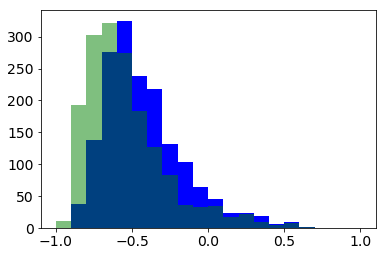

In [15]:
plt.hist(results['Pearson'],bins=20,range=(-1,1),color='blue');
plt.hist(results_linear['Pearson'],alpha=0.5,bins=20,range=(-1,1),color='green');
plt.tick_params('both',which='major', labelsize=14)

Display results from first pipeline on a map

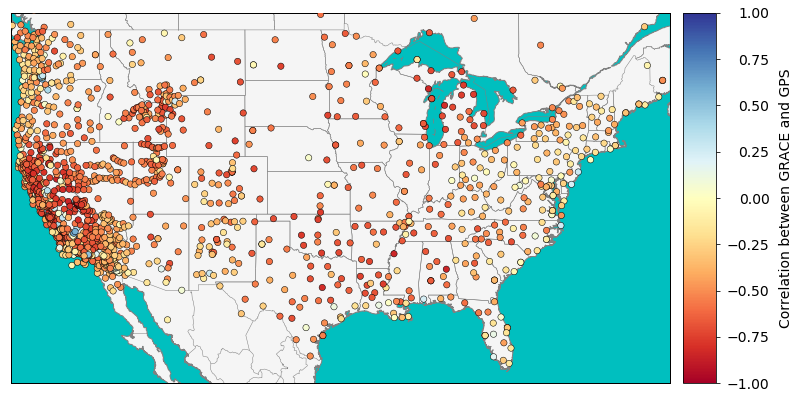

In [16]:
llat = 24
ulat = 50
llon = -125
rlon = -66

bmap = Basemap(llcrnrlat=llat, urcrnrlat=ulat, llcrnrlon=llon, 
               urcrnrlon=rlon,projection='merc', lon_0=np.mean([llon,rlon]), 
               lat_0=np.mean([llat,ulat]), resolution='i', area_thresh=10000)

# Setup figure
fig     = plt.figure()
ax      = fig.gca()
fig.set_size_inches(11,8)

# Draw appropriate items on map
bmap.drawcoastlines(color='grey')
bmap.drawmapboundary(fill_color='c')
bmap.fillcontinents(color='whitesmoke', lake_color='c', ax=None, zorder=None, alpha=None)
bmap.drawstates(color='grey');
bmap.drawcountries(color='grey', linewidth=0.5);

# Plot correlations on map
# Some GPS points overlap, so different orders 
# will make the map look slightly different
bmap.scatter(results['Lon'].as_matrix(), results['Lat'].as_matrix(), zorder=10,
             c=results['Pearson'].as_matrix(), latlon=True,cmap='RdYlBu',s=40,vmin=-1,vmax=1,linewidth=0.5,
             edgecolor='black')
c1 = bmap.colorbar()
c1.set_label('Correlation between GRACE and GPS',fontsize=14,labelpad=10)
plt.tight_layout()

# Align numbers on colorbar
for t in c1.ax.get_yticklabels():
        t.set_horizontalalignment('right')  
        c1.ax.yaxis.set_tick_params(pad=50)
        t.set_fontsize(14)

        


Plot histogram of Pearson - Spearman correlations

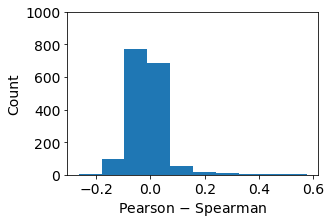

In [17]:
plt.gcf().set_size_inches(4.5,3);
plt.hist((results['Pearson'] - results['Spearman']).dropna());
plt.xlabel('Pearson $-$ Spearman', fontsize=14);
plt.ylabel('Count',fontsize=14);
plt.gca().tick_params(axis='both', which='major', labelsize=14);
plt.ylim(0,1000);

Zoom in on Minnesota

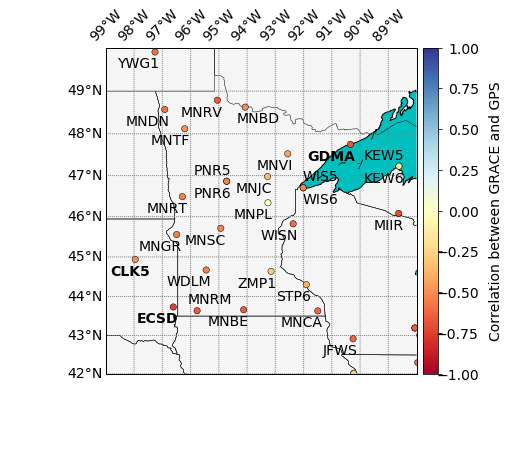

In [18]:
llat = 42
ulat = 50
llon = -99
rlon = -88

mn_bmap = Basemap(llcrnrlat=llat, urcrnrlat=ulat, llcrnrlon=llon, 
              urcrnrlon=rlon,projection='merc', lon_0=np.mean([llon,rlon]), 
              lat_0=np.mean([llat,ulat]), resolution='h',area_thresh=10000)

# Plot map of minnesota
fig = plt.figure()
fig.set_size_inches(6,6)

ax = fig.gca()

# Draw 
mn_bmap.drawcoastlines(color='black')
mn_bmap.drawmapboundary(fill_color='c')
mn_bmap.fillcontinents(color='whitesmoke', lake_color='c', ax=None, alpha=None)
mn_bmap.drawstates(color='black');
mn_bmap.drawcountries(color='black', linewidth=0.5);


for label, data in results.iterrows():
    x,y = mn_bmap(metadata.loc[label]['Lon'],metadata.loc[label]['Lat'])
    
    # GPS site labels can overlap. If a station is listed, it's label will 
    # have a different spot 
    if label == 'MNRM':
        ax.annotate(label, xy=(x,y), xytext=(35,7), ha='right', textcoords='offset points', fontsize=14);
    elif label == 'KEW5':
        ax.annotate(label, xy=(x,y), xytext=(5,7), ha='right', textcoords='offset points', fontsize=14);
    elif label == 'WIS5':
        ax.annotate(label, xy=(x,y), xytext=(35,7), ha='right', textcoords='offset points', fontsize=14);
    elif label == 'WIS6':
        ax.annotate(label, xy=(x,y), xytext=(35,-16), ha='right', textcoords='offset points', fontsize=14);
    elif label == 'PNR5':        
        ax.annotate(label, xy=(x,y), xytext=(5,7), ha='right', textcoords='offset points', fontsize=14);
    elif label == 'MNBD':
        ax.annotate(label, xy=(x,y), xytext=(35,-16), ha='right', textcoords='offset points', fontsize=14 );

    # These objects are near the edge, and so no label is displayed
    elif label in ('RIS5','RIS6', 'WIM5','WIM6'):
        pass
    
    # The time series of these stations are plotted, so make them bold
    elif label == 'CLK5':
        ax.annotate(label, xy=(x,y), xytext=(15,-16), ha='right', textcoords='offset points', 
                    fontsize=14,fontweight='bold');
    elif label in ('ECSD','GDMA'):
        ax.annotate(label, xy=(x,y), xytext=(5,-16), ha='right', textcoords='offset points', 
                    fontsize=14,fontweight='bold'); 
    
    # If no other rule applies, use a standard label position
    else:
        ax.annotate(label, xy=(x,y), xytext=(5,-16), ha='right', textcoords='offset points', fontsize=14);        

# Plot correlations on map
mn_bmap.scatter(results['Lon'].as_matrix(), results['Lat'].as_matrix(), zorder=10,
                c=results['Pearson'].as_matrix(), latlon=True,cmap='RdYlBu',s=40,vmin=-1,vmax=1,linewidth=0.5,
                edgecolor='black')

# Add a colorbar
colorbar = mn_bmap.colorbar()
colorbar.ax.tick_params(labelsize=14) 

colorbar.set_label('Correlation between GRACE and GPS',fontsize=14,labelpad=10)

# Align colorbar labels
for t in colorbar.ax.get_yticklabels():
        t.set_horizontalalignment('right')  
        colorbar.ax.yaxis.set_tick_params(pad=37)

# Rotate labels        
meridians = mn_bmap.drawmeridians(np.arange(llon,rlon,1),labels=[0,0,1,0],fontsize=14,color='grey');
for m in meridians:
    try:
        meridians[m][1][0].set_rotation(45);
    except:
        pass
    
mn_bmap.drawparallels(np.arange(llat,ulat,1),labels=[1,0,0,0], fontsize=14,color='grey');

Plot first three timeseries in Minnesota

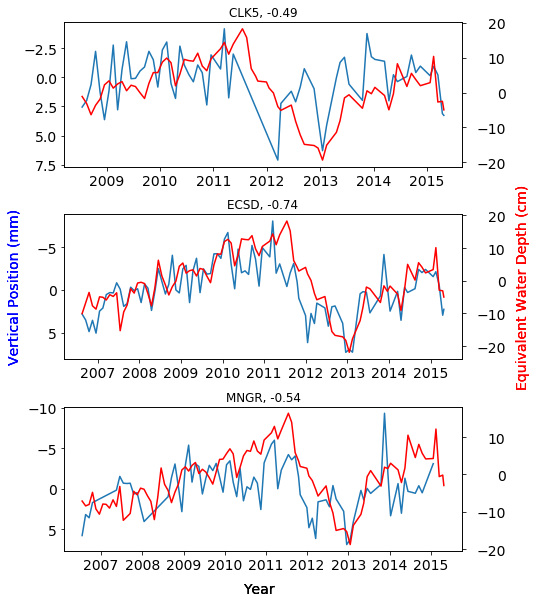

In [19]:
# Set range around minnesota
mn_lat_range = (43,49)
mn_lon_range = (-98,-89)

# Collect Data around minnesota
station_data = dict()
for station in data_dict.keys():
    if (mn_lat_range[0] < metadata.loc[station]['Lat'] < mn_lat_range[1] and \
       mn_lon_range[0] < metadata.loc[station]['Lon'] < mn_lon_range[1]):               
            
        station_data[station] = data_dict[station]
        
mn_data = pd.Panel.from_dict(station_data,orient='minor')

num_data_sets = len(mn_data.minor_axis)
graphs_per_plot = 3 
num_plots = int(np.ceil(num_data_sets / graphs_per_plot))

# Loop over all minnesota data and plot in groups of 3
# Note we break after the first 3 are plotted
for i in range(num_plots):

   
    start_plot = i*graphs_per_plot
    end_plot = min(i*graphs_per_plot+graphs_per_plot,num_data_sets)
    plot_index = range(start_plot,end_plot)
    num_graphs = plot_index[-1] - plot_index[0] + 1

    fig = plt.figure()
    # print(num_graphs)
    fig.set_size_inches(10*0.7,0.8*3.4*num_graphs)
    for j in plot_index:
        
        # Setup plots
        plt.subplot(num_graphs,1,j-start_plot+1);
        station = mn_data.minor_axis[j]
        index = mn_data.loc['dU',:,station].index[np.argwhere(mn_data.loc['dU',:,station].index == mn_data.loc['dU',:,station].dropna().index[0])[0][0]:]
        locs, labels = plt.xticks()
        plt.tick_params(axis='both', which='major', labelsize=14)
        ax = plt.gca()
        ax2 = ax.twinx()     

        # Set labels
        fig.text(-0.01, 0.505, 'Vertical Position (mm)', va='center', rotation='vertical', fontsize=14, color='blue')
        fig.text(1.0, 0.505, 'Equivalent Water Depth (cm)', va='center', rotation='vertical',fontsize=14,color='red')
        fig.text(0.4605,-0.01, 'Year',va='center',rotation='horizontal',fontsize=14)
    

        # plot vertical position
        ax.plot(mn_data['dU',index,station].dropna()*1000)
        # Invert y axis
        ax.invert_yaxis()
        # Plot Grace
        ax2.plot(mn_data['Grace',index,station].dropna(), color='red')
        plt.tick_params(axis='both', which='major', labelsize=14)
        
        # Right align GRACE y axis numbers
        for t in ax2.get_yticklabels():
            t.set_horizontalalignment('right')  
        ax2.yaxis.set_tick_params(pad=40)

        # Set title
        plt.title(station + ', %.2f' %results.loc[station,'Pearson'])
        plt.tight_layout()
        
    break



Plot GRACE vs MNPL

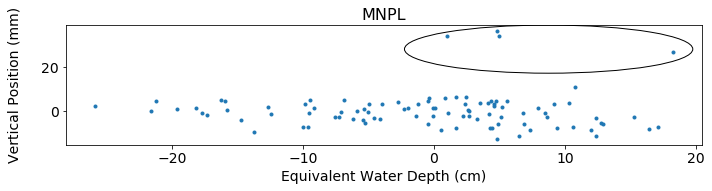

In [20]:
fig = plt.gcf()

# Get index of grace data
index = mn_data['Grace',:,'MNPL'].dropna().index
# Plot GRACE vs MNPL
plt.plot(mn_data['Grace',index,'MNPL'],mn_data['dU',index,'MNPL']*1000,'.')
# Set title
plt.title('MNPL',fontsize=16)
# Set tick fontsize
plt.tick_params(axis='both', which='major', labelsize=14)
# Set figure size
plt.gcf().set_size_inches(10,2.75)
# Set labels
plt.ylabel('Vertical Position (mm)',labelpad=20, fontsize=14)
plt.xlabel('Equivalent Water Depth (cm)',fontsize=14)
plt.tight_layout()

# Draw an ellipse in upper right
ell = Ellipse(xy=(8.75,28.25),width=22,height=22,facecolor='none',edgecolor='black');
plt.gca().add_artist(ell);

Plot GPS vertical Position using a Voronoi tesselation

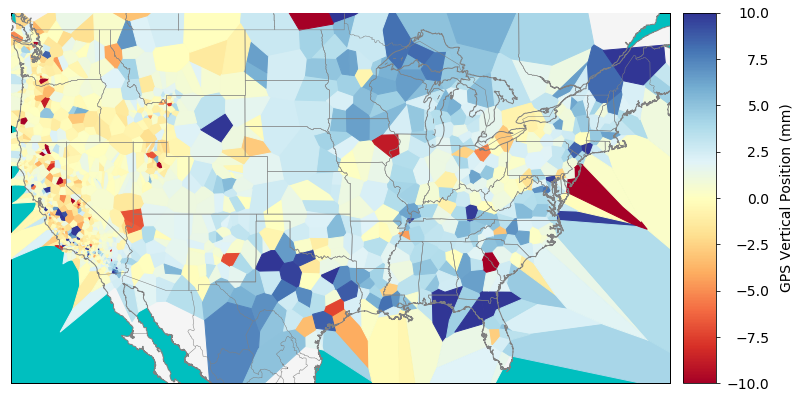

In [21]:
llat = 24
ulat = 50
llon = -125
rlon = -66

bmap = Basemap(llcrnrlat=llat, urcrnrlat=ulat, llcrnrlon=llon, 
               urcrnrlon=rlon,projection='merc', lon_0=np.mean([llon,rlon]), 
               lat_0=np.mean([llat,ulat]), resolution='i', area_thresh=10000)

# Choose date for plotting
gps_map_date = '2012-02-16'

vertical_positions = [data_dict[label].loc[gps_map_date,'dU']*1000 for label in results.index]

gps_map_data = pd.concat((metadata.loc[results.index,['Lat','Lon']],
                        pd.Series(vertical_positions,index=results.index,name='dU')),axis=1)

gps_map_data.dropna(inplace=True)

# Create plot
fig = plt.gcf()
ax = plt.gca()
fig.set_size_inches(11,8)

# Create Spherical Voronoi Tesselation
collection,sv,patch_index = getVoronoiCollection(gps_map_data,'Lat','Lon',v_name='dU',
                                                 bmap=bmap,min_v=-10,max_v=10,cmap=matplotlib.cm.get_cmap('RdYlBu'),
                                                 threshold=1e-11)

# Draw coastlines, states, etc...
bmap.drawcoastlines(color='grey',zorder=17)
bmap.drawmapboundary(fill_color='c',zorder=5)
bmap.fillcontinents(color='whitesmoke', lake_color='c', ax=None, alpha=None,zorder=10)
bmap.drawstates(color='grey',zorder=16);
bmap.drawcountries(color='grey', linewidth=0.5,zorder=16);


# Add voronoi Polygons to map
collection.zorder=15
ax.add_collection(collection);

# Create a Mappable for the colorbar
sm = plt.cm.ScalarMappable(cmap='RdYlBu',norm=plt.Normalize(vmin=-10,vmax=10))
sm._A = []

# Setup colorbar
c1 = bmap.colorbar(sm)
c1.set_label('GPS Vertical Position (mm)',fontsize=14,labelpad=10)
plt.tight_layout()

# Align numbers on colorbar
for t in c1.ax.get_yticklabels():
        t.set_horizontalalignment('right')  
        c1.ax.yaxis.set_tick_params(pad=50)
        t.set_fontsize(14)

Plot correlations using a Voronoi tessellation

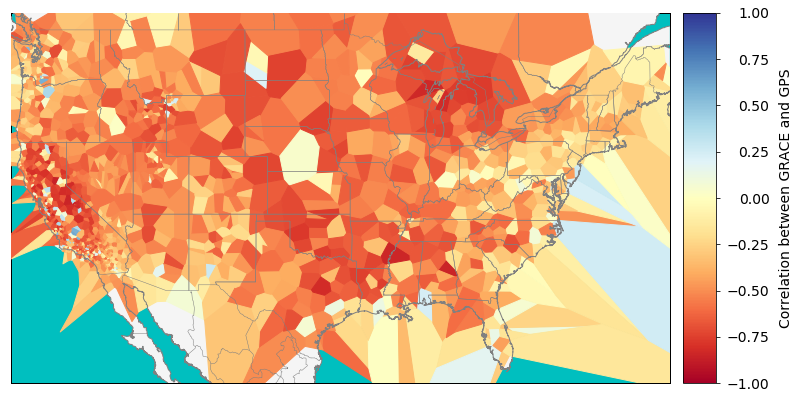

In [22]:
llat = 24
ulat = 50
llon = -125
rlon = -66

bmap= Basemap(llcrnrlat=llat, urcrnrlat=ulat, llcrnrlon=llon, 
              urcrnrlon=rlon,projection='merc', lon_0=np.mean([llon,rlon]), 
              lat_0=np.mean([llat,ulat]), resolution='i', area_thresh=10000)

# Setup figure
fig     = plt.figure()
ax      = fig.gca()
fig.set_size_inches(11,8)


collection,sv,patch_index = getVoronoiCollection(results,'Lat','Lon',v_name='Pearson',
                                                 bmap=bmap, threshold=1e-11)

# Draw different parts of the map
bmap.drawcoastlines(color='grey',zorder=11)
bmap.drawmapboundary(fill_color='c',zorder=8)
bmap.fillcontinents(color='whitesmoke', lake_color='c', ax=None, zorder=9, alpha=None)
bmap.drawstates(color='grey',zorder=11);
bmap.drawcountries(color='grey', linewidth=0.5,zorder=11);

# Setup collection of polygons
collection.zorder=10
collection.set_clim(-1,1)
collection.set_array(results.iloc[patch_index]['Pearson'])
collection.set_cmap('RdYlBu')
collection.set_edgecolor('face')


# Add voronoi Polygons to map
ax.add_collection(collection);

# Add colorbar
c1 = bmap.colorbar(collection)
c1.set_label('Correlation between GRACE and GPS',fontsize=14, labelpad=10)

plt.tight_layout()

# Align numbers on colorbar
for t in c1.ax.get_yticklabels():
        t.set_horizontalalignment('right')  
        c1.ax.yaxis.set_tick_params(pad=50)
        t.set_fontsize(14)